# Прогнозирование заказов такси

## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).

## Содержание

1. [Изучение и обработка данных](#start)
2. [Обучение моделей](#model_training)       
3. [Лучшая модель](#the_best_of_the_best)  

## 1. Изучение и обработка данных<a id="start"></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

Предварительно посмотрев, что из себя представляет датасет в код для открытия таблицы добавил **index_col=[0], parse_dates=[0]**.

In [2]:
try:
    taxi = pd.read_csv('D:/Users/Иван/Downloads/Прогнозирование заказов такси/taxi.csv', index_col=[0], parse_dates=[0])
except:
    taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
taxi.head(20)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [3]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Чтобы проверить, в хронологическом ли порядке расположены даты и время, воспользуемся атрибутом индекса таблицы **is_monotonic_increasing** (англ. «монотонный»). Если порядок соблюдён, атрибут вернёт True, если нет — False.

In [4]:
print(taxi.index.is_monotonic_increasing)

True


Построим график временного ряда.

<Axes: xlabel='datetime'>

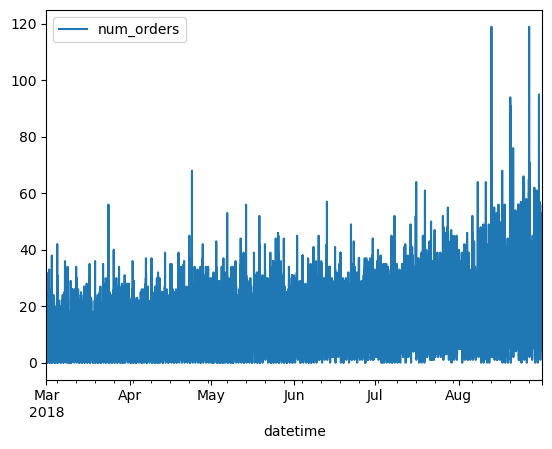

In [5]:
taxi.plot()

Построим график вызова такси по одному часу.

<Axes: xlabel='datetime'>

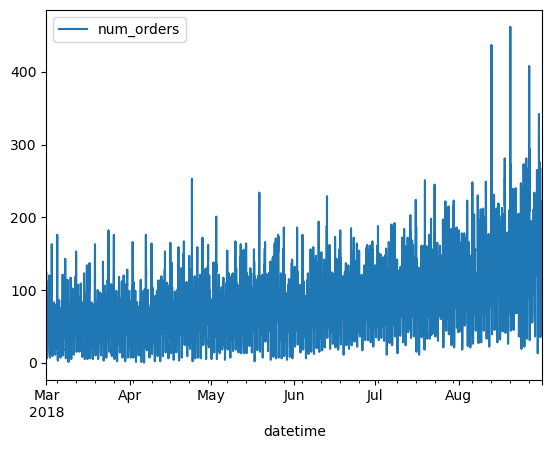

In [6]:
# Ресемплирование с интервалом 1 час ('1h')
taxi = taxi.resample('1h').sum()

# Построение графика
taxi.plot()

Добавим в столбец 'rolling_mean' скользящее среднее с размером окна, равным одной недели. Выведим на экран график.

<Axes: xlabel='datetime'>

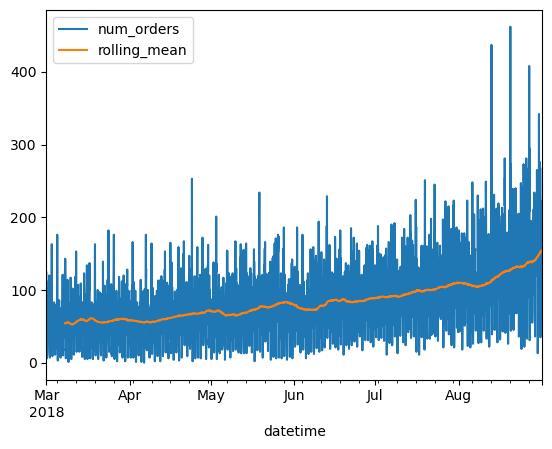

In [7]:
taxi['rolling_mean'] = taxi.rolling(24*7).mean()
taxi.plot()

Очевидно, что идёт рост числа заказов.

В модуле tsa.seasonal (от англ. time series analysis, «анализ временных рядов») библиотеки statsmodels (англ. «статистические модели») есть функция seasonal_decompose() (англ. «разбить на части»). Она раскладывает временной ряд на три составляющие: тренд, сезонность и остаток (англ. residuals). Это компонента, которая не объясняется трендом и сезонностью, это шум.


Разложим временной ряд на тренд и сезонную компоненту.

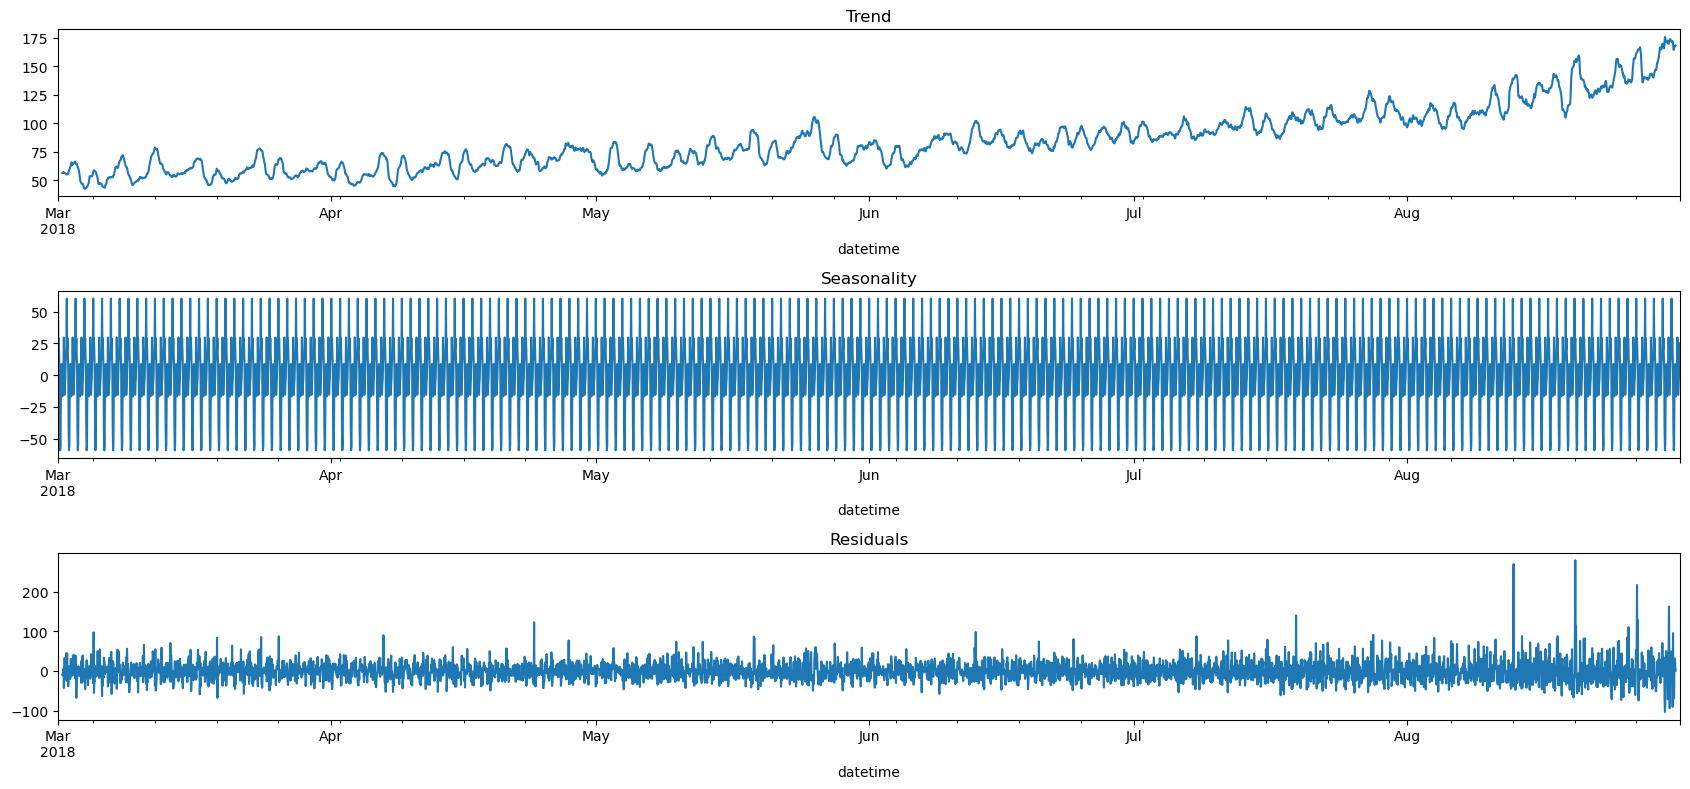

In [8]:
decomposed = seasonal_decompose(taxi['num_orders'])

plt.figure(figsize=(17, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

В целом, как и в предыдущем графике, в "Тренде" видна тенденция роста заказов.

Напишем функцию make_features() (англ. «создать признаки»), чтобы прибавить к таблице четыре новых календарных признака: год, месяц, день и день недели.

В функцию make_features() добавим аргумент max_lag, который задаст максимальный размер отставания. Новые признаки назовём: 'lag_1', 'lag_2' — и до величины max_lag.

Добавим скользящее среднее как 'rolling_mean'.

In [9]:
def make_features(taxi, max_lag, rolling_mean_size):
    taxi['dayofweek'] = taxi.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        taxi['lag_{}'.format(lag)] = taxi['num_orders'].shift(lag)

    taxi['rolling_mean'] = taxi['num_orders'].shift().rolling(rolling_mean_size).mean()
    
make_features(taxi, 2, 24)
taxi.tail()

,num_orders,rolling_mean,dayofweek,lag_1,lag_2
datetime,,,,,
2018-08-31 19:00:00,136,164.875000,4,207.0,217.0
2018-08-31 20:00:00,154,167.541667,4,136.0,207.0
2018-08-31 21:00:00,159,168.041667,4,154.0,136.0
2018-08-31 22:00:00,223,166.416667,4,159.0,154.0
2018-08-31 23:00:00,205,169.125000,4,223.0,159.0


Из выборки удалим строки с пропусками.

In [10]:
taxi = taxi.dropna()

Далее выделим из выборки целевой признак:

In [11]:
target = taxi['num_orders']
features = taxi.drop(['num_orders', 'rolling_mean'], axis=1)

Разобьём датасет на обучающую, валидационную и тестовую выборки так, чтобы размер тестовой составил 10% от исходной. Функция **train_test_split()** из модуля **sklearn.model_selection** по умолчанию перемешивает данные. Поэтому укажем аргумент **shuffle** (с англ. «перетасовывать») равным **False**, чтобы разделить данные корректно:

In [12]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.2, shuffle=False)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, 
                                                                              shuffle=False)
print(features_train.shape, features_valid.shape, features_test.shape)
print(target_train.shape, target_valid.shape, target_test.shape)

(3513, 3) (439, 3) (440, 3)
(3513,) (439,) (440,)


Создадим словарь для итоговой таблицы:

In [13]:
final_table = {}

- Проверили соблюден ли порядок признаков;
- Выявили рост числа заказов;
- Написали функцию для добавления новых признаков и максимального размера отставания;
- Разбили датасет на обучающую, валидационную и тестовую выборки;
- Удалили строки с пропусками.

## 2. Обучение моделей<a id="model_training"></a>

### LinearRegression

In [14]:
model_lr = LinearRegression()

In [15]:
%%time

model_lr.fit(features_train, target_train)

CPU times: total: 31.2 ms
Wall time: 105 ms


LinearRegression()

In [16]:
%%time

predicted_valid = model_lr.predict(features_valid)
rmse_valid_lr = mean_squared_error(target_valid, predicted_valid) ** 0.5
print('RMSE', rmse_valid_lr)

RMSE 43.74987729574733
CPU times: total: 0 ns
Wall time: 2.35 ms


In [17]:
final_table['LinearRegression']  = [rmse_valid_lr, '87.9 ms', '3 ms']

### RandomForestRegressor

In [18]:
%%time

parameters = {'n_estimators': range(10,101,20),'max_depth': range(1,8,3), 'min_samples_leaf': range(1,5,2), 'min_samples_split': range(2,6,2)}
model_rfr =  RandomForestRegressor(random_state=12345)
grid = GridSearchCV(model_rfr, parameters, scoring='neg_mean_squared_error')
grid.fit(features_train, target_train)

grid.best_params_

CPU times: total: 22.3 s
Wall time: 22.5 s


{'max_depth': 4,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 90}

In [19]:
%%time
model_rfr = RandomForestRegressor(max_depth=4, min_samples_leaf=1, min_samples_split=4, n_estimators=90, random_state=12345)
model_rfr.fit(features_train, target_train)
predicted_valid = model_rfr.predict(features_valid)
rmse_valid_rfr = mean_squared_error(target_valid, predicted_valid) ** 0.5
print('RMSE', rmse_valid_rfr,)


RMSE 45.11743461491362
CPU times: total: 156 ms
Wall time: 152 ms


In [20]:
final_table['RandomForestRegressor']  = [rmse_valid_rfr, '5.4 s', '9.99 ms']

### CatBoostRegressor

In [21]:
tscv = TimeSeriesSplit(n_splits=2)

In [22]:
%%time

parameters_cbr = {'learning_rate': np.logspace(-3, 0, 5),'iterations': range(20, 60, 20),'depth': range(5,10,2)}
model_cbr =  CatBoostRegressor(loss_function='RMSE', silent=True, random_seed=12345)
model_cbr.fit(features_train, target_train, verbose=30)
gsearch_cbr = GridSearchCV(model_cbr, parameters_cbr, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)    
gsearch_cbr.fit(features_train, target_train);    
gsearch_cbr.best_params_
    

Learning rate set to 0.049934
0:	learn: 35.2395529	total: 137ms	remaining: 2m 17s
30:	learn: 29.6970537	total: 198ms	remaining: 6.19s
60:	learn: 28.9689020	total: 226ms	remaining: 3.48s
90:	learn: 28.6414062	total: 253ms	remaining: 2.53s
120:	learn: 28.3888480	total: 279ms	remaining: 2.03s
150:	learn: 28.1904062	total: 305ms	remaining: 1.71s
180:	learn: 27.9897297	total: 330ms	remaining: 1.49s
210:	learn: 27.7831666	total: 356ms	remaining: 1.33s
240:	learn: 27.6216302	total: 381ms	remaining: 1.2s
270:	learn: 27.4370639	total: 407ms	remaining: 1.09s
300:	learn: 27.2803506	total: 433ms	remaining: 1s
330:	learn: 27.1173825	total: 459ms	remaining: 927ms
360:	learn: 26.9863155	total: 485ms	remaining: 858ms
390:	learn: 26.8363867	total: 510ms	remaining: 794ms
420:	learn: 26.6936842	total: 536ms	remaining: 737ms
450:	learn: 26.5670736	total: 561ms	remaining: 683ms
480:	learn: 26.4129332	total: 586ms	remaining: 633ms
510:	learn: 26.2793528	total: 612ms	remaining: 586ms
540:	learn: 26.1289700	t

{'depth': 5, 'iterations': 20, 'learning_rate': 0.1778279410038923}

In [23]:
%%time

model_cbr = CatBoostRegressor(depth=5, iterations=20, learning_rate=0.1778279410038923,
                              loss_function='RMSE', silent=True, random_seed=12345)
model_cbr.fit(features_train, target_train, verbose=30)
predicted_valid = model_cbr.predict(features_valid)
rmse_valid_cbr = mean_squared_error(target_valid, predicted_valid) ** 0.5
print('RMSE', rmse_valid_cbr)

0:	learn: 34.0414821	total: 979us	remaining: 18.6ms
19:	learn: 28.9819827	total: 23.5ms	remaining: 0us
RMSE 45.47749848934299
CPU times: total: 62.5 ms
Wall time: 38.7 ms


In [24]:
final_table['CatBoostRegressor']  = [rmse_valid_cbr, '1.98 s', '2 ms']

Соберём все результаты, чтобы сравнить и решить, какую модель допустить к тестовой выборке:

In [25]:
final_table = pd.DataFrame.from_dict(data=final_table,
                                     columns=['RMSE', 'Время обучения (fit)', 'Время предсказания'],
                                     orient='index')
final_table

,RMSE,Время обучения (fit),Время предсказания
LinearRegression,43.749877,87.9 ms,3 ms
RandomForestRegressor,45.117435,5.4 s,9.99 ms
CatBoostRegressor,45.477498,1.98 s,2 ms


Значения **RMSE** ниже 48 продемонстрировали все модели, но лучше всех показала себя **LinearRegression**.

## 3. Лучшая модель<a id="the_best_of_the_best"></a>

Для итогового теста перезапишем features и target в соотношении 9:1.

In [26]:
train_features, test_features, train_target, test_target = train_test_split(features, target, test_size=0.1, shuffle=False)

print(train_features.shape, test_features.shape, train_target.shape, test_target.shape)

(3952, 3) (440, 3) (3952,) (440,)


In [27]:
%%time

model_lr.fit(train_features, train_target)

CPU times: total: 0 ns
Wall time: 2.07 ms


LinearRegression()

In [28]:
%%time

predicted_test = model_lr.predict(test_features)
rmse_test = mean_squared_error(test_target, predicted_test) ** 0.5
print('RMSE', rmse_test)

RMSE 56.68703363368628
CPU times: total: 0 ns
Wall time: 1.01 ms


In [29]:
#выделяем два дня
two_days = taxi['2018-08-29':'2018-08-31']
two_days_features = two_days.drop(['rolling_mean', 'num_orders'], axis=1)
two_days_target = two_days['num_orders']
#получаем предсказания для этих двух дней
two_days_predicted_test = model_lr.predict(two_days_features)

Для лучшего понимания результатов моделирования временных рядов подготовим выборку по последним двум дням датасета и посмотрим на графике расхождение факт/предсказанное

In [30]:
two_days = two_days.drop(['rolling_mean', 'dayofweek','lag_1', 'lag_2'], axis=1)

In [31]:
two_days['predicted'] = two_days_predicted_test.tolist()
two_days.head()

,num_orders,predicted
datetime,,
2018-08-29 00:00:00,234,137.657225
2018-08-29 01:00:00,152,167.337853
2018-08-29 02:00:00,163,132.023382
2018-08-29 03:00:00,126,128.757666
2018-08-29 04:00:00,136,111.341240


<Axes: xlabel='datetime'>

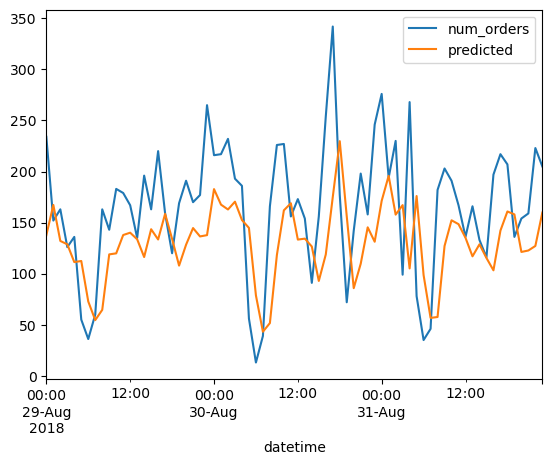

In [32]:

two_days.plot()

In [33]:
%%time

model_cbr = CatBoostRegressor(depth=5, iterations=20, learning_rate=0.1778279410038923, loss_function='RMSE', 
                              silent=True, random_seed=12345)
model_cbr.fit(train_features, train_target, verbose=1)
predicted_test_cbr = model_cbr.predict(test_features)
rmse_test_cbr = mean_squared_error(test_target, predicted_test) ** 0.5
print('RMSE', rmse_test_cbr)

0:	learn: 36.7108978	total: 1.38ms	remaining: 26.2ms
1:	learn: 35.3385440	total: 2.61ms	remaining: 23.5ms
2:	learn: 34.2721686	total: 3.64ms	remaining: 20.6ms
3:	learn: 33.4528718	total: 4.62ms	remaining: 18.5ms
4:	learn: 32.9169934	total: 5.96ms	remaining: 17.9ms
5:	learn: 32.5002778	total: 6.93ms	remaining: 16.2ms
6:	learn: 32.1945974	total: 7.8ms	remaining: 14.5ms
7:	learn: 31.9280281	total: 8.78ms	remaining: 13.2ms
8:	learn: 31.7651210	total: 9.61ms	remaining: 11.8ms
9:	learn: 31.6064388	total: 10.6ms	remaining: 10.6ms
10:	learn: 31.4500978	total: 11.4ms	remaining: 9.32ms
11:	learn: 31.3335966	total: 12.2ms	remaining: 8.12ms
12:	learn: 31.2475491	total: 13ms	remaining: 7ms
13:	learn: 31.1666154	total: 14ms	remaining: 6.01ms
14:	learn: 31.1092004	total: 14.9ms	remaining: 4.96ms
15:	learn: 31.0556241	total: 15.7ms	remaining: 3.93ms
16:	learn: 31.0355350	total: 16.4ms	remaining: 2.89ms
17:	learn: 30.9816285	total: 17.2ms	remaining: 1.91ms
18:	learn: 30.9679028	total: 17.8ms	remaining:

In [34]:
predicted_two_days_cbr = model_cbr.predict(two_days_features)

In [35]:
two_days['predicted_cbr'] = predicted_two_days_cbr.tolist()


<Axes: xlabel='datetime'>

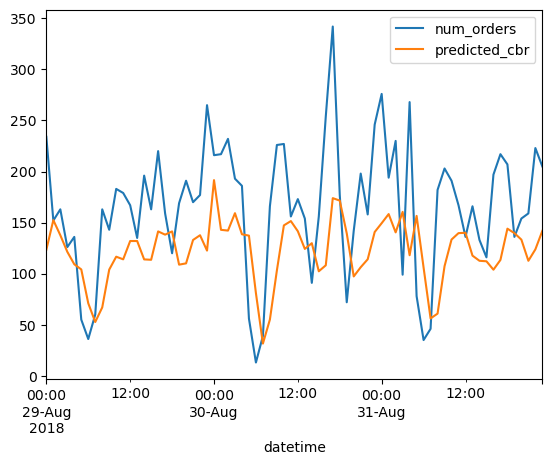

In [36]:
two_days = two_days.drop(['predicted'], axis=1)
two_days.plot()

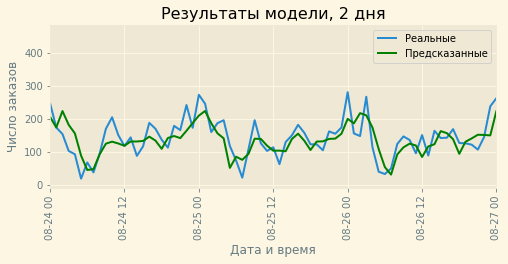